In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

## Timespan (30days, 60days, 180days, 1year, 2years, all)
start = '2010-12-10'
##Open data
data = pd.read_csv('https://community-api.coinmetrics.io/v2/assets/btc/metricdata.csv?metrics=PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,IssContNtv,SplyCur&start='+start, index_col = 0, parse_dates=True)

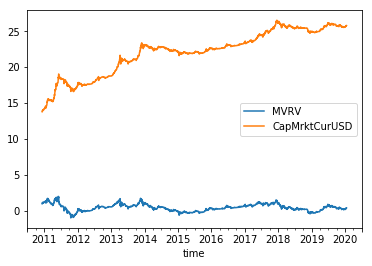

In [2]:
## MVRV

## MVRV Ratio
data['MVRV'] = data['CapMrktCurUSD'] / data['CapRealUSD']
## MVRV-z
per = 30
data['MVRV-z'] = (data['MVRV'] - data['MVRV'].rolling(per).mean()) / data['MVRV'].rolling(per).std()

## Chart
np.log(data[['MVRV', 'CapMrktCurUSD']]).plot()

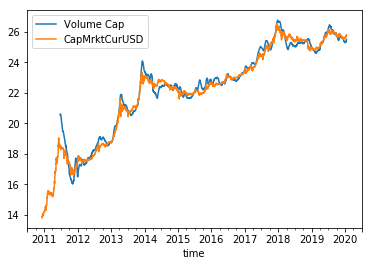

In [3]:
## NVT

## NVT Ratio
per = 90
data['NVT'] = data['CapMrktCurUSD'] / data['TxTfrValAdjUSD'].rolling(per).mean()
## Volume Cap
per1 = 20
data['Volume Cap'] = (data['NVT'].rolling(per).mean() * data ['TxTfrValAdjUSD']).rolling(per1).mean()
## Deviation
data['Dev Vol Cap'] = (data['Volume Cap'] - data['CapMrktCurUSD']) / data['CapMrktCurUSD']

## Chart
np.log(data[['Volume Cap', 'CapMrktCurUSD']]).plot()

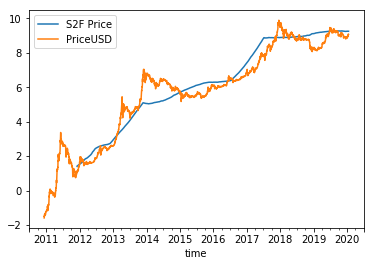

In [4]:
## Stock-to-Flow

## S2F Ratio
data['S2F'] = data['SplyCur'] / data['IssContNtv'].rolling(360).sum()
## S2F Price
data['S2F Price'] = np.exp(-1.84) * data['S2F'] ** 3.36
## S2F 360d discounting Satoshi's tokens (1MM BTC)
data['disc S2F'] = (data['SplyCur'] - 1000000) / data['IssContNtv'].rolling(360).sum()
## Deviation
data['Dev S2F'] = (data['S2F Price'] - data['PriceUSD']) / data['PriceUSD']

## Chart
np.log(data[['S2F Price', 'PriceUSD']]).plot()

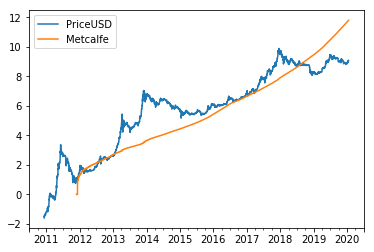

In [6]:
## Metcalfe's Law

## Blockchain.com wallets data
timespan = 'all'
w_data = pd.read_csv('https://api.blockchain.info/charts/my-wallet-n-users?timespan='+timespan+'&format=csv', header=None, infer_datetime_format =True)
w_data.columns = ['Date', 'nWallets']
## Parsing date
w_data['Date'] = w_data['Date'].str.split(' ', expand=True)
w_data['Date'] = pd.to_datetime(w_data['Date'], format='%Y-%m-%d')
## Eliminate 'intra day' data
w_data['Date'] = w_data['Date'].drop_duplicates(keep = 'last')
w_data = w_data[w_data['Date'].notnull()]
## Date to index
w_data.set_index('Date', inplace=True, drop=True)

## Merge dataframes
data = pd.concat([data, w_data], axis=1, sort=True, join='outer')
## Fill empty cells
data['nWallets'] = data['nWallets'].ffill(axis = 0)
## Transaction pairs (mil)
data['Tx Pairs'] = data['nWallets'] * (data['nWallets'] - 1) / 2
## Gompertz Sigmoid
data['G_Sigmoid'] = data['SplyCur'] * np.log(21000000 / data['SplyCur'])
## Metcalfe value
a = 900000
data['Metcalfe (log)'] = a * np.log(data['Tx Pairs']) / data['G_Sigmoid']
data['Metcalfe'] = np.exp(data['Metcalfe (log)'])
## Deviation
data['Dev Metcalfe'] = (data['Metcalfe'] - data['PriceUSD']) / data['PriceUSD']

## Chart

np.log(data[['PriceUSD', 'Metcalfe']]).plot()

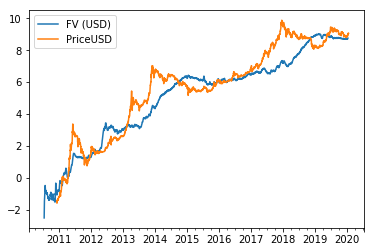

In [7]:
## Quantity Theory of Money

# fv = pd.read_csv('Desktop/Monografia/fv_bitcoin_usd.csv', parse_dates=True)
fv = pd.read_csv('fv_bitcoin_usd.csv', parse_dates=True)

## Parsing date
fv['DateTime'] = fv['DateTime'].str.split(' ', expand=True)
fv['DateTime'] = pd.to_datetime(fv['DateTime'], format='%Y-%m-%d')
## Date to index
fv.set_index('DateTime', inplace=True, drop=True)
## Merge dataframes
data = pd.concat([data, fv], axis=1, sort=True, join='outer')
## Fixing dates
data['FV (USD)'] = pd.to_numeric(data['FV (USD)'], errors='coerce')
## Deviation
data['Dev FV'] = (data['FV (USD)'] - data['PriceUSD']) / data['PriceUSD']

## Chart
np.log(data[['FV (USD)', 'PriceUSD']]).plot()

In [49]:
## Defining events
# Start
ev0 = '2011-06-01'
# Mt. Gox hack
ev1 = '2014-02-07'
# 2015 bottom to reversal
ev2 = '2015-08-24'
# CME futures
ev3 = '2017-12-18'

## Sectioning by date
alltime = data[data.index > ev0]
data.loc[(data.index > ev0) & (data.index <= ev1), 'age'] = 0
data.loc[(data.index > ev1) & (data.index <= ev2), 'age'] = 1
data.loc[(data.index > ev2) & (data.index <= ev3), 'age'] = 2
data.loc[data.index > ev3, 'age'] = 3

## Mapper with ages to rename columns
ages_names = {'all_time': 'all time', 
              0 : 'Genesis - Mt. Gox hack',
              1 : 'Mt.Gox hack - 2015 bottom',
              2 : '2015 bottom - CME futures',
              3 : 'CME futures - now'
             }

In [54]:
## Test for each metric
tests_names = ['NVT', 'S2F', 'Metcalfe', 'FV']
metrics_dev = ['Dev Vol Cap', 'Dev S2F', 'Dev Metcalfe','Dev FV']
## Dict to hold DataFrames
tests = {}
## List to iterate throught ages
ages = range(4)

# Iterate throught each metric
for metric, test in zip(metrics_dev, tests_names):
    # DataFrame to store the results
    df = pd.DataFrame()
    
    # Defining bins limits
    bins_limits = [data[metric].min(), .2, .5, 1, data[metric].max()]
    # Calculating frenquency for all time
    df['all_time'] = data[metric].value_counts(normalize=True, sort=False, bins=bins_limits)
    
    # Iterate throught each age    
    for age in ages:
        # Selecting age
        work_data = data[data['age'] == age]
        # Calculate and append to df the results
        df[age] = work_data[metric].value_counts(normalize=True, sort=False, bins=bins_limits)
    
    # Change columns' names
    df = df.rename(columns=ages_names)
    # Append df to dict
    tests[test] = df

# Check results
tests['NVT']

,all time,Genesis - Mt. Gox hack,Mt.Gox hack - 2015 bottom,2015 bottom - CME futures,CME futures - now
"(-0.677, 0.2]",0.586286,0.523422,0.765542,0.573790,0.795784
"(0.2, 0.5]",0.185537,0.254582,0.170515,0.272727,0.088274
"(0.5, 1.0]",0.096514,0.103870,0.049734,0.139315,0.114625
"(1.0, 7.227]",0.032844,0.094705,0.014210,0.014168,0.001318


In [ ]:
## Gráficos

fig, (ax1) = plt.subplots()
fig.suptitle('S2F x PriceUSD')
ax1.scatter(np.log(data['S2F_360d']), np.log(data['PriceUSD']))

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Market Cap x NVT')
ax1.plot(data.index, np.log(data['PriceUSD']))
ax2.plot(data.index, np.log(data['S2F Price']))

#data[['CapMrktCurUSD', 'Volume Cap']].plot(linewidth=2, markersize=50)
plt.show()